# Input Maker for String-method simulations.

With this notebook you will be able to prepare the input files for string-method simulation as well as the optional preparatory steering simulation. The necessary `.mdp` files will be generated, the cvs will be defined as well as optionally the initial string. 

This notebook only deals with cvs that are distances between atoms or centers of mass of groups of atoms. Nevertheless, we invite you to try it to understand the logic of the pull coordinates and mdp file creation so you can later adapt it to your own cvs (dihedrals, angles etc). The main limitation of the CVs that can be used is the feature availability of the pull-code of gromacs. 

Let's get started!

Make sure you have installed the imports in this library. 

In [2]:
import sys
import MDAnalysis as mda
import numpy as np
import glob
import matplotlib.pyplot as plt
from math import ceil
import os
import shutil
import pickle

In [3]:
def distance_atom_groups(u, sel1, sel2, progressbar=True, center_of_mass=False):
    """
    Calculate the distance between the centers of geometry (or mass) between two groups (sel1, sel2) as a function of time in the trajectory trj.

    Parameters
    ----------
    u: MDA universe to analyz trajectory to analyze.
    sel1: MDA selection containing at least 1 atom.
    sel2: MDA selection containing at least 1 atom.
    center_of_mass: Use the center of mass instead of center of geometry.
    progressbar: Show progressbar.

    Returns
    -------
    d: matplotlib figure object.
    """
    from MDAnalysis import Universe
    from MDAnalysis import AtomGroup
    from numpy import array
    from tqdm import tqdm
    from numpy.linalg import norm

    assert isinstance(u, Universe), "u should be a MDAnlaysis universe."
    assert isinstance(sel1, AtomGroup), "sel1 should be a MDAnlaysis universe."
    assert isinstance(sel2, AtomGroup), "sel2 should be a MDAnlaysis universe."
    assert isinstance(progressbar, bool), "progressbar should be boolean."
    assert sel1.n_atoms >= 1, "sel1 should have at least 1 atom."
    assert sel2.n_atoms >= 1, "sel2 should have at least 1 atom."

    d = []
    for i, ts in tqdm(
        enumerate(u.trajectory), total=u.trajectory.n_frames, disable=not progressbar
    ):
        if center_of_mass:
            csel1 = sel1.center_of_mass()
            csel2 = sel2.center_of_mass()
        else:
            csel1 = sel1.centroid()
            csel2 = sel2.centroid()
        d.append([ts.dt * i, norm(csel1 - csel2)])
    return array(d)

## Choosing starting and final configurations

With `start.gro` and `end.gro` are used to define the initial and final values of the cvs in the string.

Note that since `.gro` files don't always have the best topology information might need to add some sort of topology file like so:
```python
start = mda.Universe('topology/top.pdb', 'topology/start.gro')
```
Of course, `start.pdb` or `end.pdb` can also be used directly

In [4]:
start = mda.Universe("topology/start.gro")
# start = mda.Universe('topology/top.pdb', 'topology/start.gro')
end = mda.Universe("topology/end.gro")
# end = mda.Universe('topology/top.pdb', 'topology/end.gro')

/home/sperez/data_partition/bin2/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


## Choosing number of bead on string

Choose the number of beads of the string. This should be done keeping in mind the parallelization conditions that will be used and if the first and last strings of the bead will be mobile or fixed. For the @DelemotteLab HPC environment 34 beads (32 of them moving) is a good starting point. Additional information about the parallelization can be found in the main `README.md` of the repository.

In [5]:
n_beads = 32 + 2

## Defining the CVs

The dictionary `ndx_groups` defines the index groups that will be added to `index0.ndx` and will be used by gmx to calculate the string cvs. The key-value pairs of the dictionary are the alias of the index group (no spaces please) and the `MDAnalysis` selection-string of the group. You can read more about MDAnalysis selections [here](https://docs.mdanalysis.org/stable/documentation_pages/selections.html). 

The cvs will be the distances between the centers of mass of the consequtive pairs of groups.

In this example bellow there would be two CVs: 
```python 
ndx_groups = {
    "CA_77_A": "name CA and resid 77 and segid PROA",
    "CA_77_B": "name CA and resid 77 and segid PROB",
    "112_A": "resid 112 and segid PROA",
    "13_C": "resid 13 and segid PROC",
}
```
1. The distance between CA atoms of resid 77 of segid PROA and resid 77 of segment PROB.
2. The distance between the center of mass of resid 112 of segid PROA and the center of mass of resid 13 of segid PROC. 

For this example we will use other CVs special for GPCRs. In this case we will select the atoms by using their index number. If a group or groups are involved in two distances, for the set up of this notebook, its best to write them twice in this list with a slightly different name. This is the case for `a_4334`  which is involved in two distances with `a_863` and also `a_1971`. For this reason we add the entries `a_863b` and also `a_1971b`.

In [6]:
ndx_groups = {
    "a_863": "bynum 863",
    "a_4334": "bynum 4334",
    "a_1971": "bynum 1971",
    "a_3340": "bynum 3340",
    "a_1462": "bynum 1462",
    "a_3459": "bynum 3459",
    "a_3203": "bynum 3203",
    "a_3318": "bynum 3318",
    "a_4334_b": "bynum 4334",
    "a_1971_b": "bynum 1971",
}
n_groups = len(ndx_groups.keys())

The next cell will show you which pairs will be used as cvs:

In [7]:
cvs = []
for i in range(1, len(ndx_groups) + 1, 2):
    cvs.append([i, i + 1])
n_cvs = len(cvs)
print("Pairs of groups whose distance are cvs:")
keys_groups = list(ndx_groups.keys())
for i in range(n_cvs):
    print(f"{keys_groups[cvs[i][0]-1]} - {keys_groups[cvs[i][1]-1]}")

Pairs of groups whose distance are cvs:
a_863 - a_4334
a_1971 - a_3340
a_1462 - a_3459
a_3203 - a_3318
a_4334_b - a_1971_b


## Choosing force constants

The list `kappas` contains the force constants for the steered simulation, the restrained portions of the string-simulation and the swarms of the the string-simulation.

The force constant of the swarm simulation should always be 0.

In [8]:
kappas = [10000.0, 10000.0, 0.0]
assert kappas[2] == 0.0, "The kappa of the swarm simulation should be 0"

These are the printing frequency of the cvs (pull-coordinates), best not to modify.

In [9]:
nstxout = [50000, 5000, 5000]

## Making the input files:

At this point you need to modify `swarms.mdp`, `restrained.mdp` and `steered.mdp`. There are instructions inside of which parts need to be modified. The pull section will be modified by this notebook.

The cell bellow will append the pull-coord parameters to the `mdp` files and append the groups for cvs to `index0.ndx` generating `index.ndx`.

A pickle file with the `cvs`and `ndx_groups` will be generated for future reference.

If you are re-running this notebook to check the steering simulation set `write_mdps = False`.

In [10]:
write_mdps = True

In [11]:
pickle.dump([cvs, ndx_groups], open("cv.pkl", "wb"))

shutil.copy("topology/index0.ndx", "topology/index.ndx")

for key in ndx_groups.keys():
    group = start.select_atoms(ndx_groups[key])
    group.write("topology/index.ndx", name=key, mode="a")

files = [
    open(file, "r").readlines()
    for file in ["mdp/steered.mdp", "mdp/restrained.mdp", "mdp/swarms.mdp"]
]

for j, file in enumerate(files):
    final_line = len(file)
    for i, line in enumerate(file):
        if line.strip() == ";start pull":
            final_line = i
            break
    if line.strip() != ";start pull":
        file.append(";start pull")
    files[j] = file[0 : final_line + 1]

for f, file in enumerate(files):
    file.append("\n")
    file.append("pull = yes\n")
    file.append(f"pull-ngroups = {n_groups}\n")
    file.append("\n")
    for i, key in enumerate(ndx_groups.keys()):
        file.append(f"pull-group{i+1}-name = {key}\n")
    file.append("\n")
    file.append(f"pull-ncoords = {n_cvs}\n")
    for i, cv in enumerate(cvs):
        if len(cv) == 2:
            file.append(f"pull-coord{i+1}-geometry = distance\n")
            file.append(f"pull-coord{i+1}-k = {kappas[f]}\n")
            g = " ".join(str(e) for e in cv)
            file.append(f"pull-coord{i+1}-groups = {g}\n")
    file.append("\n")
    file.append("pull-print-components = no\n")
    file.append(f"pull-nstxout = {nstxout[f]}\n")
    file.append("pull-nstfout = 0\n")

if write_mdps:
    for f, file_string in enumerate(
        ["mdp/steered.mdp", "mdp/restrained.mdp", "mdp/swarms.mdp"]
    ):
        with open(file_string, "w") as file:
            for line in files[f]:
                file.write(line)

/home/sperez/data_partition/bin2/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:728: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


Now that the `.mdp` files and indeces have been made it is always a good idea to check them out and see they do what you want them to. The pull coordinates are missing some parameters that are automatically added during simulation. Here are mdp parameters of gmx for [reference](https://manual.gromacs.org/documentation/2020/user-guide/mdp-options.html#com-pulling).

## Making the initial string `string0.txt`

If you have made your own string you can skip this section and place its corresponding file in `strings/string0.txt`. Remember this file must follow the `np.savetxt` format and have shape (n_bead, ncvs).

If you don't have a string0.txt. You can created with the code below. The code makes a linear interpolation between the value of the CVs at `start.gro` and `end.gro`. If you want something fancier, you can program any thing you want.

In [12]:
dis_s = []
dis_e = []
for cv in cvs:
    dis_s.append(
        distance_atom_groups(
            start,
            start.select_atoms(ndx_groups[list(ndx_groups.keys())[cv[0] - 1]]),
            start.select_atoms(ndx_groups[list(ndx_groups.keys())[cv[1] - 1]]),
            progressbar=False,
            center_of_mass=True,
        )[0][1]
    )
    dis_e.append(
        distance_atom_groups(
            end,
            end.select_atoms(ndx_groups[list(ndx_groups.keys())[cv[0] - 1]]),
            end.select_atoms(ndx_groups[list(ndx_groups.keys())[cv[1] - 1]]),
            progressbar=False,
            center_of_mass=True,
        )[0][1]
    )
dis_s = np.array(dis_s)
dis_e = np.array(dis_e)

/home/sperez/data_partition/bin2/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py:865: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


If your atoms groups have more than 1 atom. With the code bellow you can check the masses of the atoms used in the groups to see if something is fishy:

In [13]:
print("Masses for the start config.")
print(" ")
for key in ndx_groups.keys():
    mass = start.select_atoms(ndx_groups[key]).masses
    print(f"Masses of {key}: ", end=" ")
    for i in mass:
        print(i, end=" ")
    print()
print(" ")
print("Masses for the end config.")
print(" ")
for key in ndx_groups.keys():
    mass = end.select_atoms(ndx_groups[key]).masses
    print(f"Masses of {key} ", end=" ")
    for i in mass:
        print(i, end=" ")
    print()

Masses for the start config.
 
Masses of a_863:  12.011 
Masses of a_4334:  12.011 
Masses of a_1971:  12.011 
Masses of a_3340:  12.011 
Masses of a_1462:  12.011 
Masses of a_3459:  12.011 
Masses of a_3203:  12.011 
Masses of a_3318:  12.011 
Masses of a_4334_b:  12.011 
Masses of a_1971_b:  12.011 
 
Masses for the end config.
 
Masses of a_863  12.011 
Masses of a_4334  12.011 
Masses of a_1971  12.011 
Masses of a_3340  12.011 
Masses of a_1462  12.011 
Masses of a_3459  12.011 
Masses of a_3203  12.011 
Masses of a_3318  12.011 
Masses of a_4334_b  12.011 
Masses of a_1971_b  12.011 


Instead of linspace you can make your own function to create the string. Remember that MDAnalysis uses Å but gmx needs the string in nm!!

In [14]:
string = np.linspace(dis_s, dis_e, n_beads) / 10

Print out the string.

In [15]:
np.savetxt("strings/string0.txt", string)

## Visualize the string

Independently of if you have made your own string or with this program you can visualize it with the cell bellow. 

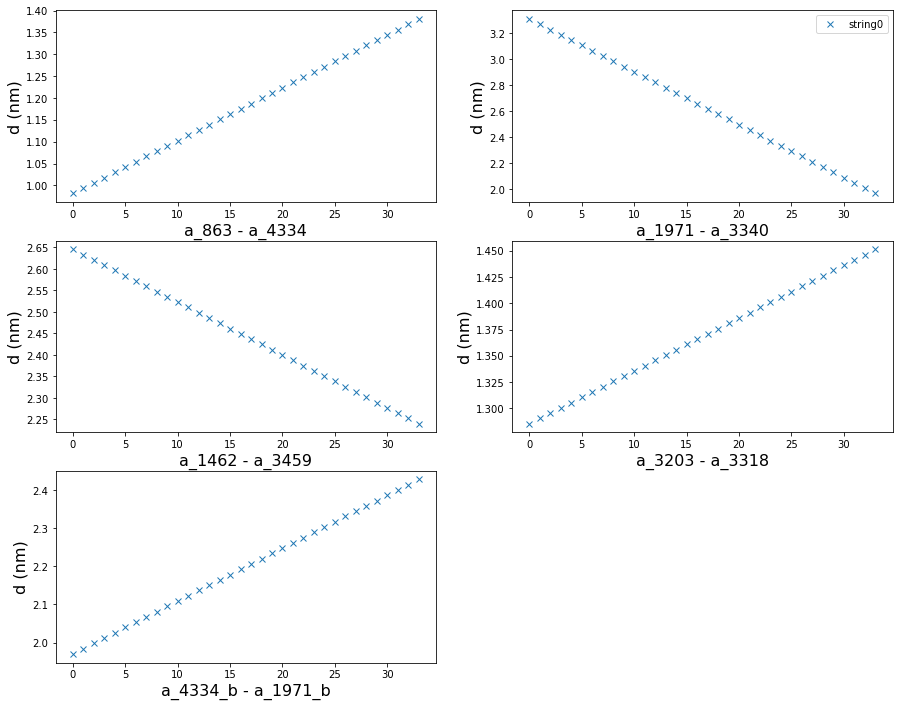

In [16]:
string = np.loadtxt("strings/string0.txt")
n_plots = string.shape[1]
fig, ax = plt.subplots(ceil(n_plots / 2), 2, figsize=(15, 4 * ceil(n_plots / 2)))
ax = ax.flatten()
for i in range(n_plots):
    ax[i].plot(string[:, i], ls="", marker="x", label="string0")
    ax[i].set_xlabel(
        f"{list(ndx_groups.keys())[2*i]} - {list(ndx_groups.keys())[2*i+1]}", size=16
    )
    ax[i].set_ylabel("d (nm)", size=16)
    ax[i].tick_params(axis="both", which="major", labelsize=13)
ax[1].legend()
if n_plots % 2:
    fig.delaxes(ax[-1])

## Next steps

At this point, we are ready to prepared to run the steering simulations if needed. Refer to the README.md for further indications.